# Time Series Clustering for Retail Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import seaborn as sns

df = pd.read_csv('../data/sample-2/processed/revenue_ts_matrix.csv')

# Set StoreID as index
df.set_index('StoreID', inplace=True)

# Display the first few rows of the dataset
print("Original dataset:")
df.head()

Original dataset:


,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2022-06-21,2022-06-22,2022-06-23,2022-06-24,2022-06-25,2022-06-26,2022-06-27,2022-06-28,2022-06-29,2022-06-30
StoreID,,,,,,,,,,,,,,,,,,,,,
1,6510.12,3683.01,1943.75,6051.44,1843.92,3888.35,1579.77,4618.63,4960.50,7140.28,...,4503.31,3775.15,3142.35,3069.50,2001.21,3300.05,1406.00,4323.99,5973.25,3427.51
2,12407.68,8714.52,3659.43,5417.80,4547.52,4946.04,5397.98,10396.10,9255.98,6484.20,...,4850.77,5644.12,8023.42,4158.62,7593.82,4972.22,3569.29,8593.40,8344.90,7264.55
3,4594.43,9152.73,3332.79,2319.01,8776.75,3279.88,5164.65,6550.87,6288.41,6604.59,...,954.04,2804.48,3812.66,5494.12,6223.77,8915.52,3108.03,4814.26,5849.46,8014.86
4,8111.78,11736.54,3085.22,2484.14,6289.78,4800.08,3176.76,6367.23,7887.70,1853.37,...,5214.55,4661.52,733.43,5793.67,5993.43,13406.79,5986.30,4068.70,3877.35,3441.99
5,7853.66,9878.44,4579.28,4345.18,5803.97,3078.29,8059.59,2530.69,8265.90,3895.92,...,7837.45,4446.95,2492.00,4238.35,4608.66,8516.14,6537.48,3476.44,4282.24,9586.15


## Preprocess the Time Series Data

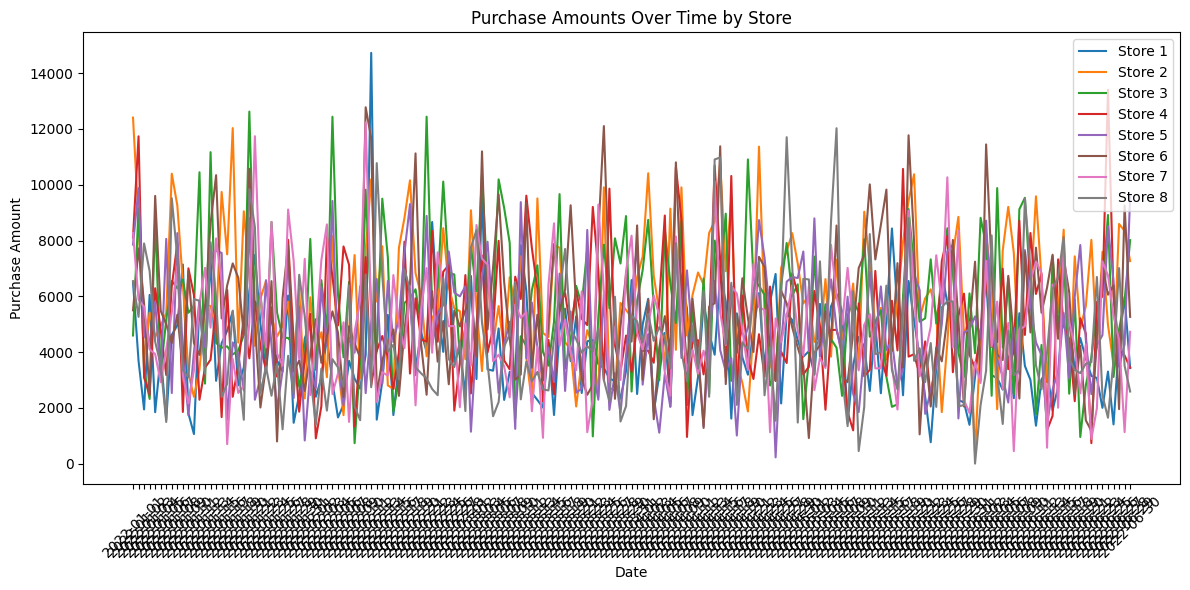

In [2]:
# Transpose the DataFrame so that each row represents a time series for a store
df_transposed = df.T

# Visualize the time series for each store
plt.figure(figsize=(12, 6))
for store in df_transposed.columns:
    plt.plot(df_transposed.index, df_transposed[store], label=f'Store {store}')
plt.title('Purchase Amounts Over Time by Store')
plt.xlabel('Date')
plt.ylabel('Purchase Amount')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Standardize the data (optional but recommended for clustering)
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    index=df.index,
    columns=df.columns
)

# Convert the scaled data to a numpy array for tslearn
time_series_data = df_scaled.values

## Apply Time Series Clustering

### Option 1: Traditional K-means on features

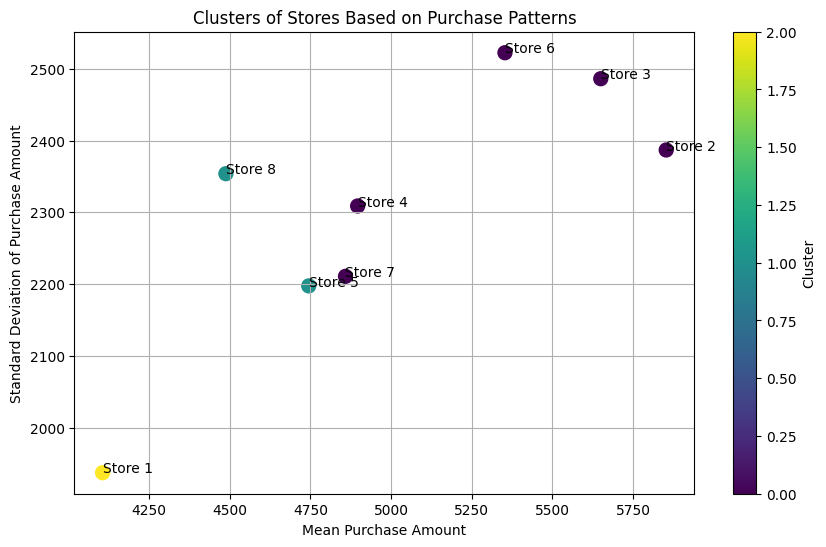

In [7]:
# Extract basic statistical features from each time series
def extract_features(df):
    features = pd.DataFrame(index=df.index)
    features['mean'] = df.mean(axis=1)
    features['std'] = df.std(axis=1)
    features['min'] = df.min(axis=1)
    features['max'] = df.max(axis=1)
    features['median'] = df.median(axis=1)
    return features

features_df = extract_features(df)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
features_df['cluster'] = kmeans.fit_predict(features_df)

# Visualize clusters based on mean and standard deviation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_df['mean'], features_df['std'], 
                      c=features_df['cluster'], cmap='viridis', s=100)
plt.xlabel('Mean Purchase Amount')
plt.ylabel('Standard Deviation of Purchase Amount')
plt.title('Clusters of Stores Based on Purchase Patterns')
plt.colorbar(scatter, label='Cluster')
for i, store in enumerate(features_df.index):
    plt.annotate(f'Store {store}', (features_df['mean'].iloc[i], features_df['std'].iloc[i]))
plt.grid(True)
plt.show()

## Option 2: Time Series-specific K-means (using DTW distance)

c:\Users\Khor Kean Teng\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Khor Kean Teng\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


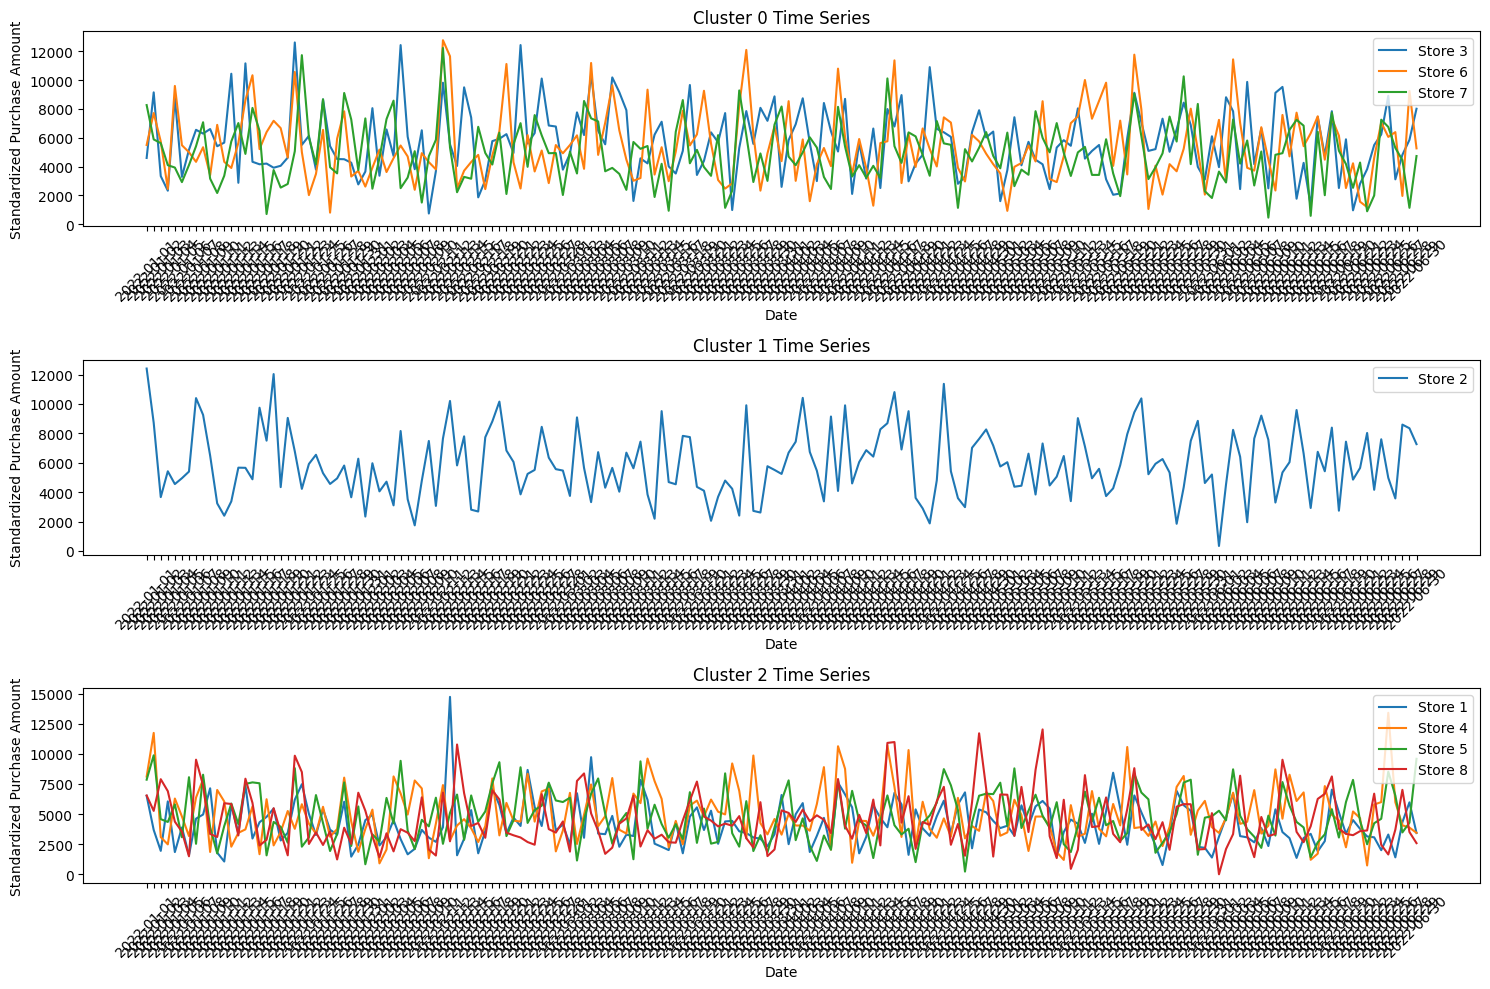

In [4]:
# Reshape data for tslearn (samples, timestamps, features)
time_series_reshaped = df_scaled.values.reshape(df_scaled.shape[0], df_scaled.shape[1], 1)

# Apply time series K-means with DTW (Dynamic Time Warping) distance
ts_kmeans = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=42)
ts_clusters = ts_kmeans.fit_predict(time_series_reshaped)

# Add cluster labels to original data
df['ts_cluster'] = ts_clusters

# Visualize each cluster's time series
plt.figure(figsize=(15, 10))
for cluster_id in range(3):
    plt.subplot(3, 1, cluster_id+1)
    cluster_stores = df[df['ts_cluster'] == cluster_id].drop('ts_cluster', axis=1)
    for store_id, row in cluster_stores.iterrows():
        plt.plot(cluster_stores.columns, row.values, label=f'Store {store_id}')
    plt.title(f'Cluster {cluster_id} Time Series')
    plt.xlabel('Date')
    plt.ylabel('Standardized Purchase Amount')
    plt.legend()
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Option 3: Hierarchical Clustering

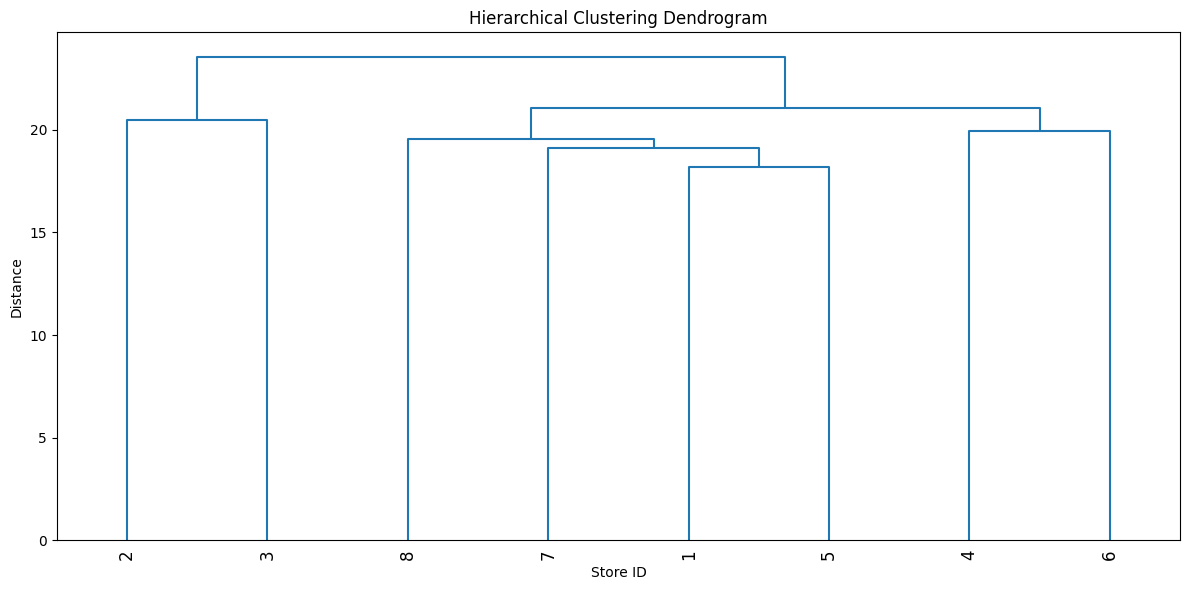

Cluster assignments by different methods:
         K-means Features  Time Series K-means  Hierarchical
StoreID                                                     
1                       2                    2             2
2                       0                    1             0
3                       0                    0             0
4                       0                    2             1
5                       1                    2             2
6                       0                    0             1
7                       0                    0             2
8                       1                    2             2


In [5]:
# Apply hierarchical clustering
linked = linkage(df_scaled, 'ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=df_scaled.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Store ID')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Cut the dendrogram to get 3 clusters
hc = AgglomerativeClustering(n_clusters=3)
df['hc_cluster'] = hc.fit_predict(df_scaled)

# Compare clusters from different methods
comparison = pd.DataFrame({
    'K-means Features': features_df['cluster'],
    'Time Series K-means': df['ts_cluster'],
    'Hierarchical': df['hc_cluster']
})
print("Cluster assignments by different methods:")
print(comparison)

## Analyze Cluster Characteristics

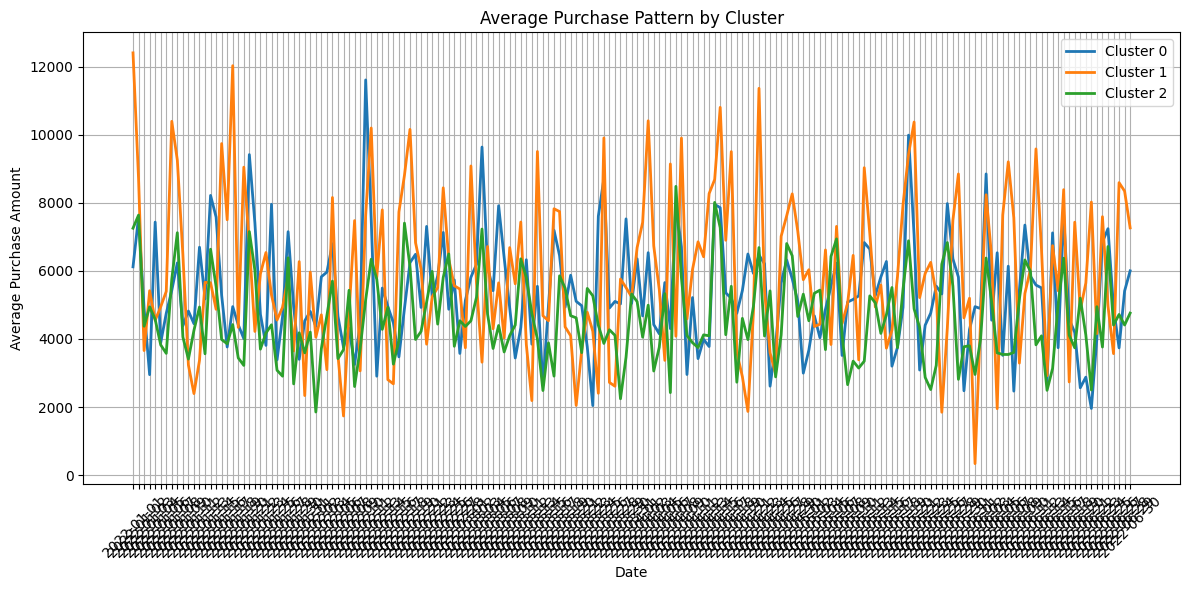


Cluster 0 Summary Statistics:
Stores in cluster: [3, 6, 7]
Average purchase amount: 5345.39
Purchase variability: 1923.73

Cluster 1 Summary Statistics:
Stores in cluster: [2]
Average purchase amount: 5917.19
Purchase variability: nan

Cluster 2 Summary Statistics:
Stores in cluster: [1, 4, 5, 8]
Average purchase amount: 4608.95
Purchase variability: 1843.19


In [6]:
# Calculate mean time series for each cluster from DTW-based clustering
plt.figure(figsize=(12, 6))

for cluster_id in range(3):
    cluster_stores = df[df['ts_cluster'] == cluster_id].drop(['ts_cluster', 'hc_cluster'], axis=1, errors='ignore')
    mean_ts = cluster_stores.mean(axis=0)
    plt.plot(mean_ts.index, mean_ts.values, linewidth=2, label=f'Cluster {cluster_id}')

plt.title('Average Purchase Pattern by Cluster')
plt.xlabel('Date')
plt.ylabel('Average Purchase Amount')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistics for each cluster
for cluster_id in range(3):
    cluster_stores = df[df['ts_cluster'] == cluster_id].drop(['ts_cluster', 'hc_cluster'], axis=1, errors='ignore')
    print(f"\nCluster {cluster_id} Summary Statistics:")
    print(f"Stores in cluster: {cluster_stores.index.tolist()}")
    print(f"Average purchase amount: {cluster_stores.mean().mean():.2f}")
    print(f"Purchase variability: {cluster_stores.std().mean():.2f}")